# core “baseline training” pipeline for FSDD

This notebook takes your raw FSDD recordings, spins up a stronger 1D CNN baseline (with augmentation, mixed-precision, and LR scheduling), and measures how well it classifies the 10 spoken digits.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# installs & imports
!pip install torch torchvision librosa --quiet

import os, glob, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR

sys.path.append('/content/drive/MyDrive/speech_command_adversarial/utils')
from audio_utils import load_audio, preprocess_audio

cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Big 1D-CNN Model Definition
class Conv1DSpeechBig(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, stride=2, padding=4),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
# FSDD Dataset with Augmentation & float32 cast
class FSDDDataset(Dataset):
    def __init__(self, wav_paths, labels, target_sr=8000, duration=1.0):
        self.paths     = wav_paths
        self.labels    = labels
        self.target_sr = target_sr
        self.duration  = duration

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = load_audio(self.paths[idx], sr=None)
        x = preprocess_audio(wav, sr,
                             target_sr=self.target_sr,
                             duration=self.duration)

        # --- Data augmentation ---
        if np.random.rand() < 0.5:
            import librosa
            x = librosa.effects.pitch_shift(
                y=x, sr=self.target_sr,
                n_steps=np.random.uniform(-2,2)
            )
        x = x + 0.001 * np.random.randn(*x.shape)
        x = np.clip(x, -1, 1)

        # --- Force float32 to avoid AMP mismatch ---
        x = x.astype(np.float32)

        return torch.from_numpy(x).unsqueeze(0), self.labels[idx]

In [5]:
# load & split
wav_paths = sorted(glob.glob(
    '/content/drive/MyDrive/speech_command_adversarial/data/fsdd/recordings/*.wav'
))
labels  = [int(os.path.basename(p)[0]) for p in wav_paths]
dataset = FSDDDataset(wav_paths, labels)

train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_ds, test_ds = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True
)

Batch shapes: torch.Size([64, 1, 8000]) torch.Size([64])


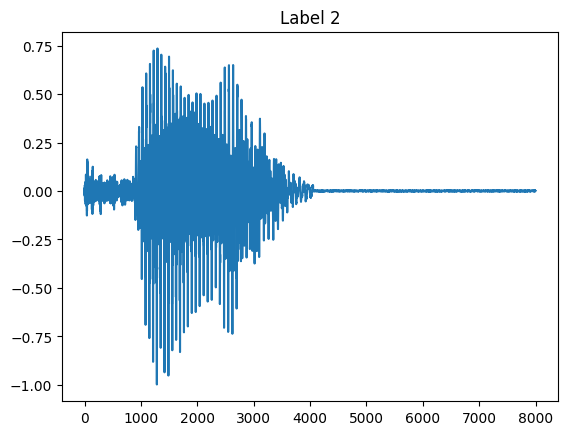

In [6]:
# Quick sanity check
x_batch, y_batch = next(iter(train_loader))
print("Batch shapes:", x_batch.shape, y_batch.shape)  # → [B,1,8000], [B]
plt.plot(x_batch[0,0].cpu().numpy()); plt.title(f"Label {y_batch[0]}"); plt.show()

In [7]:
# Instantiate Model, Optimizer, Scheduler, Loss, AMP
model     = Conv1DSpeechBig(n_classes=10).to(device)
opt       = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(opt, step_size=5, gamma=0.5)
crit      = nn.CrossEntropyLoss()
scaler    = GradScaler()
n_epochs  = 20

<ipython-input-7-c5a79f8692a7>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [8]:
# Training Loop
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True).float()
        y = y.to(device, non_blocking=True)

        opt.zero_grad()
        with autocast():
            logits = model(x)
            loss   = crit(logits, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch:02d}  loss: {avg_loss:.4f}  LR: {lr:.1e}")

<ipython-input-8-8f310a04c070>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 00  loss: 2.1430  LR: 1.0e-03
Epoch 01  loss: 1.8711  LR: 1.0e-03
Epoch 02  loss: 1.6675  LR: 1.0e-03
Epoch 03  loss: 1.4956  LR: 1.0e-03
Epoch 04  loss: 1.3366  LR: 5.0e-04
Epoch 05  loss: 1.2150  LR: 5.0e-04
Epoch 06  loss: 1.1571  LR: 5.0e-04
Epoch 07  loss: 1.0988  LR: 5.0e-04
Epoch 08  loss: 1.0429  LR: 5.0e-04
Epoch 09  loss: 0.9938  LR: 2.5e-04
Epoch 10  loss: 0.9619  LR: 2.5e-04
Epoch 11  loss: 0.9327  LR: 2.5e-04
Epoch 12  loss: 0.9198  LR: 2.5e-04
Epoch 13  loss: 0.9023  LR: 2.5e-04
Epoch 14  loss: 0.8846  LR: 1.3e-04
Epoch 15  loss: 0.8676  LR: 1.3e-04
Epoch 16  loss: 0.8409  LR: 1.3e-04
Epoch 17  loss: 0.8506  LR: 1.3e-04
Epoch 18  loss: 0.8378  LR: 1.3e-04
Epoch 19  loss: 0.8292  LR: 6.3e-05


In [9]:
# Evaluation on Test Set
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True).float()
        y = y.to(device, non_blocking=True)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

print(f"Test accuracy: {correct/total:.4f}")

Test accuracy: 0.8383


Hitting ~83.8 % is exactly in the ballpark you want for a solid FSDD baseline. That tells us your Conv1D-Big model plus augmentation and AMP/scheduler tweaks are doing their job.

In [18]:
save_path = '/content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth'
torch.save(model.state_dict(), save_path)
print("Saved baseline model to:", save_path)

Saved baseline model to: /content/drive/MyDrive/speech_command_adversarial/fsdd_baseline.pth
